<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDM_ZTM_DL/MY_CODE/07_MILE_STONE_PROJECT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARIES

In [8]:
!wget https://raw.githubusercontent.com/tronghieu2810/DEEP-LEARNING/main/helper_DL.py

--2022-03-27 06:07:41--  https://raw.githubusercontent.com/tronghieu2810/DEEP-LEARNING/main/helper_DL.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17141 (17K) [text/plain]
Saving to: ‘helper_DL.py’

helper_DL.py        100%[===================>]  16.74K  --.-KB/s    in 0.001s  

2022-03-27 06:07:41 (30.4 MB/s) - ‘helper_DL.py’ saved [17141/17141]



In [5]:
!pip install colorama
!pip install tensorflow==2.4.1

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.math as tfm
import tensorflow.keras.layers as tfkl
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers.experimental import preprocessing

import helper_DL as helper

# GLOBAL VARIABLES

In [24]:
INPUT_SHAPE = (224, 224, 3)


# DATA

In [11]:
datasets_list = tfds.list_builders()
datasets_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [12]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # Returned data format: (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQ79JOL/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQ79JOL/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [13]:
# Features of data
print(ds_info.features, '\n')

# Class names
class_names = ds_info.features['label'].names
print(class_names[:10], '\n')

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
}) 

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito'] 



<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)> 


    Image shape:                             (512, 512, 3)
    Image datatype:                          <dtype: 'uint8'>
    Target class from Food101 (tensor form): 16
    Class name (str form):                   cheesecake
    

tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8) 



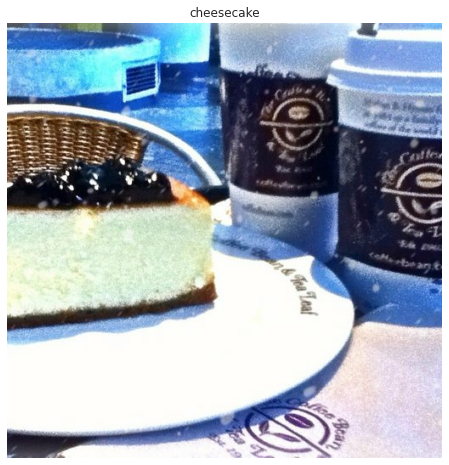

In [14]:
# Take 01 sample of the train data. Sample are in format tuple-(image_tensor, label)
train_one_sample = train_data.take(1)
print(train_one_sample, '\n')

# Output info about training sample
for (image, label) in train_one_sample:
    print(f"""
    Image shape:                             {image.shape}
    Image datatype:                          {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form):                   {class_names[label.numpy()]}
    \n""")

# The min and max values of image tensor
print(tf.reduce_min(image), tf.reduce_max(image), '\n')

# Plot an image tensor
plt.figure(figsize=(22, 8))
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.show()

# PREPROCESSING

In [15]:
# Function for preprocessing image
def preprocess_one_img(image, label, img_shape=224, scale=False):
    """
    Converts image datatype from #'float32' -> 'float32'.
    Reshapes image to [img_shape, img_shape, colour_channels]
    """

    image = tf.image.resize(image, size=[img_shape, img_shape])
    if scale:
        image = image / 255. # Scale image value

    return tf.cast(image, dtype=tf.float32), label # tuple-(float32_image, label)

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_one_img(image, label)[0]

print(f"""
Image before preprocessing:\n {image[:2]}
Shape:    {image.shape}
Datatype: {image.dtype}
""")

print(f"""
Image after preprocessing:\n {preprocessed_img[:2]}
Shape:    {preprocessed_img.shape}
Datatype: {preprocessed_img.dtype}
""")


Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]
Shape:    (512, 512, 3)
Datatype: <dtype: 'uint8'>


Image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]
Shape:    (224, 224, 3)
Datatype: <dtype: 'float32'>



# BATCH & PREPARE DATASETS

In [17]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_one_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test_data
test_data = test_data.map(map_func=preprocess_one_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32)\
                     .prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

# CALLBACKS

In [19]:
# Create callback to save a model's progress during training
checkpoint_path  = 'model_checkpoints/cp.ckpt'
model_checkpoint = tfk.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_acc',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=0)

In [20]:
tf.__version__

'2.4.1'

# MIXED PRECISION TRAINING

In [21]:
mixed_precision.set_global_policy('mixed_float16')
mixed_precision.global_policy()

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


<Policy "mixed_float16">

# FEATURE EXTRACTION MODEL

In [25]:
# Base model
base_model = tfk.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Functional model
inputs = tfkl.Input(shape=INPUT_SHAPE, name='input_layer')

x = base_model(inputs, training=False)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(len(class_names))(x)

outputs = tfkl.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)

model = tfk.models.Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tfk.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [100]:
from colorama import Fore

def check_trainable_layers(model):
    layer_idx_col      = 'No.'
    layer_name         = 'Name'
    layer_trainable    = 'Trainable'
    layer_dtype        = 'dtype'
    layer_dtype_policy = 'dtype policy'
    layer_output_shape = 'Output Shape'

    horizontal_bar = '-' * 110

    print(f'{Fore.BLACK}{layer_idx_col:^3}|{Fore.GREEN}{layer_name:^30}|{Fore.RED}{layer_trainable:^10}|{Fore.BLUE}{layer_dtype:^10}|{Fore.YELLOW}{layer_dtype_policy:^25}|{Fore.MAGENTA}{layer_output_shape:^30}')
    print(Fore.BLACK, horizontal_bar)
    for (layer_idx, layer_i) in enumerate(model.layers):
        print(f'{Fore.BLACK}{layer_idx:^3}|{Fore.GREEN}{layer_i.name:^30}|{Fore.RED}{layer_i.trainable:^10}|{Fore.BLUE}{layer_i.dtype:^10}|{Fore.YELLOW}{str(layer_i.dtype_policy):^25}|{Fore.MAGENTA}{str(layer_i.output_shape):^30}')


In [101]:
check_trainable_layers(model=model)

No.|             Name             |Trainable |  dtype   |      dtype policy       |         Output Shape         
 --------------------------------------------------------------------------------------------------------------
 0 |         input_layer          |    1     | float32  |   <Policy "float32">    |    [(None, 224, 224, 3)]     
 1 |        efficientnetb0        |    0     | float32  |<Policy "mixed_float16"> |   (None, None, None, 1280)   
 2 |   global_average_pooling2d   |    1     | float32  |<Policy "mixed_float16"> |         (None, 1280)         
 3 |            dense             |    1     | float32  |<Policy "mixed_float16"> |         (None, 101)          
 4 |       softmax_float32        |    1     | float32  |   <Policy "float32">    |         (None, 101)          


In [119]:
check_trainable_layers(model=model.layers[1])

No.|             Name             |Trainable |  dtype   |      dtype policy       |         Output Shape         
 --------------------------------------------------------------------------------------------------------------
 0 |           input_1            |    0     | float32  |   <Policy "float32">    |   [(None, None, None, 3)]    
 1 |          rescaling           |    0     | float32  |<Policy "mixed_float16"> |    (None, None, None, 3)     
 2 |        normalization         |    0     | float32  |   <Policy "float32">    |    (None, None, None, 3)     
 3 |        stem_conv_pad         |    0     | float32  |<Policy "mixed_float16"> |    (None, None, None, 3)     
 4 |          stem_conv           |    0     | float32  |<Policy "mixed_float16"> |    (None, None, None, 32)    
 5 |           stem_bn            |    0     | float32  |<Policy "mixed_float16"> |    (None, None, None, 32)    
 6 |       stem_activation        |    0     | float32  |<Policy "mixed_float16"> |    (No

In [120]:
history_100_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[helper.create_tensorboard_callback(dir_name='training_logs',
                                                                                                 experiment_name='efficientb0_101_classes_all_data_feature_extract'),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_feature_extract/20220327-074251
Epoch 1/3
2368/2368 [==============================] - 371s 143ms/step - loss: 2.3353 - accuracy: 0.4629 - val_loss: 1.2338 - val_accuracy: 0.6711


Epoch 2/3
2368/2368 [==============================] - 327s 136ms/step - loss: 1.3180 - accuracy: 0.6629 - val_loss: 1.1150 - val_accuracy: 0.7060


Epoch 3/3
2368/2368 [==============================] - 325s 136ms/step - loss: 1.1314 - accuracy: 0.7063 - val_loss: 1.0798 - val_accuracy: 0.7074


In [ ]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model